# Capstone Project #

## Problem ##
Locate candidate locations for opening a cafe within a specified square area (this example: Oxford Circus, London, UK)

### Hypothesis ###
Within large city centres it is beneficial to open coffee shops far from other cafes (far in a local sense)

### Methodolpgy ###
- identify existing coffee shop density within a grid bounded by the specified area
- calculate a per grid cell metric reflecting an inversion of this density
- metric should also take into account immediately adjacent grid cells
- high values of this metric reflect a local relative absence of coffee shops
- filter data to include only the highest 3 values of this metric
- investigate if areas of low coffee shop density show clustering characteristics
    - use elbow method to determine optimum number of clusters for k-means algorithm
- display most promising candidate clusters for opening a new coffee shop

### Data
- Existing coffee shop locations will be obtained by the foursquare explore API
- we consider a $1km^2$ area of a city centre (London) split into a 10x10 grid
    * square area is a square of side length $r=\frac{1000}{2}$
    * each grid cell has a length of $\Delta=\frac{1000}{10}$
- we query a slightly larger area than this to allow a per grid cell metric calculation taking into account adjacent cells
    * metric <- $ n_{cafes} + \frac{1}{4} * \Sigma\left( n_{adjacent_cafes}\right) $
- to include adjacent cell information the query radius (used in the foursquare API call) will be
    * $\sqrt(2)*\left(r+\Delta\right)$
- to map from grid cells to latitude/longitude we use the  __[Haversine method](http://url)__
    * assume radius of the Earth to be 6371km


In [1022]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

import folium # map rendering library
from folium.plugins import HeatMap

# create heatmap of coffee shop density
import seaborn as sns

# for nlargest method
import heapq

## Define functions that will be used later    

In [1023]:
# function that extracts the category of the venue from foursquare explore API results
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Location of interest is a 1km x 1km square region at Oxford Circus, London, UK

In [1024]:
address = 'Oxford Circus, UK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

origin=(latitude,longitude)
print('The geograpical coordinate of Oxford Circus, London, UK are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Oxford Circus, London, UK are 51.5152681, -0.1420078.


In [1025]:
CLIENT_ID = 'OHMTOUMOMO2STQQJOPPQJZECMDLITZRLNCI4TTXLIJ2JDWYT' # your Foursquare ID
CLIENT_SECRET = 'G2JZ4E15KHVMPCEZRU2WVI5JLUUW5MI5F1PY1ZW0TGTH521U' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OHMTOUMOMO2STQQJOPPQJZECMDLITZRLNCI4TTXLIJ2JDWYT
CLIENT_SECRET:G2JZ4E15KHVMPCEZRU2WVI5JLUUW5MI5F1PY1ZW0TGTH521U


In [1026]:
### radius of interest
r = 500 # 500 metres
### num grid cells
num_grid_cells = 10
### grid_cell_len
grid_cell_len = 2 * r / 10
### query_radius
query_radius = np.sqrt(2) * ( r + grid_cell_len )

print("r={} num_grid_cells={} grid_cell_len={} query_radius={}".format(r, num_grid_cells, grid_cell_len, query_radius))

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    query_radius, 
    LIMIT,
    'Coffee')
url # display URL

r=500 num_grid_cells=10 grid_cell_len=100.0 query_radius=848.5281374238571


'https://api.foursquare.com/v2/venues/explore?&client_id=OHMTOUMOMO2STQQJOPPQJZECMDLITZRLNCI4TTXLIJ2JDWYT&client_secret=G2JZ4E15KHVMPCEZRU2WVI5JLUUW5MI5F1PY1ZW0TGTH521U&v=20180605&ll=51.5152681,-0.1420078&radius=848.5281374238571&limit=100&section=Coffee'

In [1027]:
results = requests.get(url).json()
#results
cafes = results['response']['groups'][0]['items']
#cafes

In [1028]:
nearby_cafes = pd.json_normalize(cafes)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_cafes =nearby_cafes.loc[:, filtered_columns]

# filter the category for each row
nearby_cafes['venue.categories'] = nearby_cafes.apply(get_category_type, axis=1)

# clean columns
nearby_cafes.columns = [col.split(".")[-1] for col in nearby_cafes.columns]

nearby_cafes.head()

,name,categories,lat,lng
0,Kiss The Hippo,Coffee Shop,51.516438,-0.141844
1,JOLT,Coffee Shop,51.516186,-0.140462
2,JOE & THE JUICE,Juice Bar,51.516060,-0.142457
3,EL&N,Café,51.516419,-0.140266
4,Sketch,Modern European Restaurant,51.512694,-0.141529


In [1029]:
print('{} cafes and coffee shops were returned by Foursquare.'.format(nearby_cafes.shape[0]))

100 cafes and coffee shops were returned by Foursquare.


In [1030]:
# create map of london using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=15) 

# add markers to map
for lat, lng, name, cat in zip(nearby_cafes['lat'], nearby_cafes['lng'], nearby_cafes['name'], nearby_cafes['categories']):
    label = '{}, {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    #print ('lat={} lng={}'.format(lat,lng))
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london
        )  
    
folium.Circle([latitude, longitude],
    radius=query_radius
).add_to(map_london)

folium.Circle([latitude, longitude],
    radius=r
).add_to(map_london)

#HeatMap(zip(nearby_cafes['lat'], nearby_cafes['lng'])).add_to(map_london)

map_london

In [1031]:
# function to calc distance between two lat/lng points using Haversine method
# expects two lists of lat/lngs (from a dataframe) and an origin tuple
def dist_origin(lat1, lng1):
    # print ( lat1 )
    # print ( lng1 )
    # print ( origin )
    # convert to rads
    lat1 = np.radians( lat1 )
    lng1 = np.radians( lng1 )
    lat2 = np.radians( origin[0] )
    lng2 = np.radians( origin[1] )
    # haversine formula
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371* 1000 # Radius of earth in kilometers
    return c * r

In [1032]:
nearby_cafes = nearby_cafes.assign( distance_from_origin=dist_origin( nearby_cafes.lat, nearby_cafes.lng))
nearby_cafes.head(3)

,name,categories,lat,lng,distance_from_origin
0,Kiss The Hippo,Coffee Shop,51.516438,-0.141844,130.580209
1,JOLT,Coffee Shop,51.516186,-0.140462,147.845668
2,JOE & THE JUICE,Juice Bar,51.516060,-0.142457,93.443390


In [1033]:
### construct query grid
### need funcs to calc new lat/lon values from given lat/lon +/- distance in metres

r_earth = 6378 * 1000 # in metres

def add_to_lat( lat, lon, dy ):
    return lat + ( dy / r_earth ) * 180. / np.pi

def add_to_lon( lat, lon, dx ):
    return lon + ( dx / r_earth ) * 180. / np.pi / np.cos( lat * np.pi / 180. )

In [1034]:
### add grid bounds
upper_left = (add_to_lat(origin[0], origin[1], r), add_to_lon(origin[0], origin[1], -r) )
upper_right = (add_to_lat(origin[0], origin[1], r), add_to_lon(origin[0], origin[1], r) )
lower_left = (add_to_lat(origin[0], origin[1], -r), add_to_lon(origin[0], origin[1], -r) )
lower_right = (add_to_lat(origin[0], origin[1], -r), add_to_lon(origin[0], origin[1], r) )
\
### .. to map
map_london.add_child(folium.vector_layers.Rectangle(bounds=[upper_left,upper_right, lower_right, lower_left], color='red', ))
map_london

In [1035]:
lat_bins = np.linspace(upper_left[0], lower_left[0], num_grid_cells+2)
lng_bins = np.linspace(lower_left[1], lower_right[1], num_grid_cells+2)

#print( min( nearby_cafes['lat'] ) )
#print( max( nearby_cafes['lat'] ) )
#print( lat_bins )
print ( lng_bins )

#print( nearby_cafes['lat'] )
#print( nearby_cafes['lng'] )

lat_idxs = np.digitize(nearby_cafes['lat'], lat_bins)
lng_idxs = np.digitize(nearby_cafes['lng'], lng_bins)

print (lat_idxs)
print (lng_idxs)

[-0.14922559 -0.14791326 -0.14660094 -0.14528861 -0.14397629 -0.14266396
 -0.14135164 -0.14003931 -0.13872699 -0.13741466 -0.13610234 -0.13479001]
[ 5  5  5  5  9  3  7  2  4  8  4  8  8 10  9  8 10  2  2  9  1  8  8  1
  9  9  6  6  5  9  2  5  1  5  6 11  8  1  8  5  1  8 12  5  4 12  4 12
  7  7 11  9  9  8  4  9  7 12  5 12  2 12  8 12  3  7  9 10 12  9  9 11
  5 12  7  7 12 12  8  8  8  7 12  2  9  3 12 12  0  9 12  2  5 12  3  8
  6  2  1  6]
[ 6  7  6  7  6  6  3  7  5  8 10  8  7  7  6 10  9  7  7  6  7 11  2  7
  9  4 10  0  6  3  7 12  7  6  5 10 11  9  1  6 11 12 10  5 11  8  2  9
 12 11  9  0 12 12  5  0  0  1 12 11 11  6  0  9 12  0 12 12  8  0 12 11
  8 10 12  0 10 11 12 12 11  0  9  9 12 12 10 10 11 12  0 11  6 11  7  0
  0 12 12  0]


In [1051]:
cg = np.zeros( shape = (num_grid_cells+2,num_grid_cells+2 ), dtype=int )
for c in zip(lat_idxs, lng_idxs):
    cg[ c[0]-1, c[1]-1 ] += 1

In [1052]:
cg_metric = np.zeros( shape = (cg.shape[0]-2, cg.shape[1]-2), dtype=int)
### calc metric for inner grid - in this case
###    each entry within the cell counts as '1'
###    each entry in adjacent cells counts as '0.25'
for i in range(1, cg.shape[0]-1):
    for j in range( 1, cg.shape[1]-1):
        cg_metric[i-1,j-1] = np.round(cg[i][j]+0.25 * (
            cg[i-1][j-1]+cg[i-1][j]+cg[i-1][j+1]+
            cg[i][j-1]+cg[i][j+1]+
            cg[i+1][j-1]+cg[i+1][j]+cg[i+1][j+1]))
        #print('cg_metric[{},{}]=round( {} + 0.25 * ( {} + {} + {}  + {} + {}  +  {} + {} + {} ))'.format(i-1,j-1,cg[i][j],cg[i-1][j-1],cg[i-1][j],cg[i-1][j+1], cg[i][j-1], cg[i][j+1], cg[i+1][j-1], cg[i+1][j], cg[i+1][j+1]))


#### take a look at a heatmap of the metric before we invert it

<AxesSubplot:>

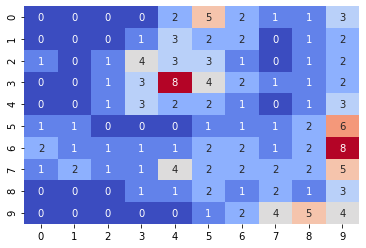

In [1039]:
sns.heatmap(cg_metric, cmap='coolwarm', annot=True, fmt='d', annot_kws={'size':10}, cbar=False)

In [1040]:
### create coord grid corresponding to the middle of each cell of the query grid
cg_lat_lookup = np.zeros( shape = cg_metric.shape[0], dtype=float )

for ilat in range( 0, cg_lat_lookup.shape[0] ):
    latval = add_to_lat(origin[0],origin[1],grid_cell_len * ( ( num_grid_cells / 2 - ilat ) - 0.5 ) )
    cg_lat_lookup[ ilat ] = latval

cg_lon_lookup = np.zeros( shape = cg_metric.shape[1], dtype=float )
for ilon in range ( 0, cg_lon_lookup.shape[0] ):
    lonval = add_to_lon( origin[0],origin[1], grid_cell_len * ( -num_grid_cells / 2 + ilon + 0.5 ) )
    cg_lon_lookup[ ilon ] = lonval

In [1041]:
cg_lat_lookup

array([51.51931061, 51.51841227, 51.51751394, 51.5166156 , 51.51571727,
       51.51481893, 51.5139206 , 51.51302226, 51.51212393, 51.51122559])

In [1042]:
cg_lon_lookup

array([-0.14850381, -0.14706025, -0.14561669, -0.14417314, -0.14272958,
       -0.14128602, -0.13984246, -0.13839891, -0.13695535, -0.13551179])

#### now lets see the invered metric - hot spots indicate areas least populated by coffee shops

In [1053]:

max_val =  np.max(cg_metric)
for ix, iy in np.ndindex( cg_metric.shape ):
    cg_metric[ ix, iy ] = np.abs( cg_metric[ ix, iy ] - max_val )

<AxesSubplot:>

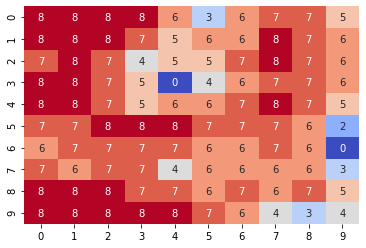

In [1044]:
sns.heatmap(cg_metric, cmap='coolwarm', annot=True, fmt='d', annot_kws={'size':10}, cbar=False)

In [1045]:
# create data matrix for cluster analysis
X=[]
for ix, iy in np.ndindex( cg_metric.shape ):
    for iz in range( 0, cg_metric[ ix, iy ] ):
        X.append( (ix, iy ) )

### Determine optimum number of clusters using Elbow method
- Perform kmeans calculation a number of times for varying numbers of clusters
- calculate the inertia for each iteration
    * inertia is the sum of squared distances of samples to closest centroid
- plot the inertia and select that value for the number of clusters after which we see a linear decrease

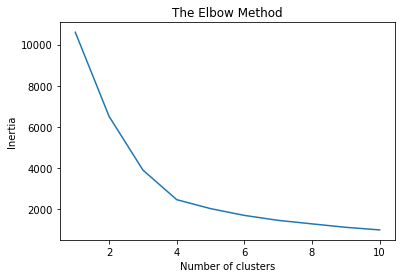

In [1046]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init = 'k-means++', max_iter=300, n_init=10, random_state = 0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss) 
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [1047]:
### spectral method didn't show any meaningful improvements over kmeans
# spectral = SpectralClustering(n_clusters=4,assign_labels='discretize',random_state=0)
# spectral_res = spectral.fit_predict(X)

In [1048]:
### from inspection of the above graph of calculated inertia values we determine that the appropriate number of clusters is 4
### k-means 
kclusters = 4
kmeans = KMeans( n_clusters = kclusters, random_state = 0)
kmeans_res = kmeans.fit_predict( X )

In [1049]:
### candidate site dataframe
df = pd.DataFrame({
    'weight':pd.Series([], dtype='int'), 
    'latitude':pd.Series([], dtype='float'), 
    'longitude':pd.Series([], dtype='float'), 
    'cluster id':pd.Series([], dtype='int')} )

### just consider the top 3 metric values
metric_vals = list(set(cg_metric.flatten()))
### get top 3
top3_mets=heapq.nlargest(3, metric_vals)

cidx=0
for ix, iy in np.ndindex( cg_metric.shape ):
    if ( cg_metric[ix][iy] in top3_mets):
        df.loc[len(df.index)] =  [ cg_metric[ix][iy], cg_lat_lookup[ ix ], cg_lon_lookup[ iy ], kmeans_res[ cidx ] ]
        cidx = cidx + cg_metric[ ix, iy ]
#df

#### construct a map showing candidate sites

In [1054]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# create map of london using latitude and longitude values
map_candidate = folium.Map(location=[latitude, longitude], zoom_start=15) 

#add markers to the map
markers_colors = []
for lat, lon, w, cluster in zip(df['latitude'], df['longitude'],  df['weight'], df['cluster id']):
    label = folium.Popup(str(w) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[round(cluster-1)],
        fill=True,
        fill_color=rainbow[round(cluster-1)],
        fill_opacity=0.6).add_to(map_candidate)

map_candidate

### Results
We see from the above map and comparison with the initial cafe plot that the results appear qualitatively reasonable; areas for further investigation are successfully identified and illustrated in an automated fashion.

### Discussion
- The clustering representation isn't entirely successful here; this results from characteristics of the simple metric used here and also the k-means algorithm which leads to some cluster overlapping
- the within each cluster are sites of varying degress of merit (in this case values in: 6; 7; 8)
- only distance from other cafes is taken into account

Future enhancements could include
- adding retail site costs to the metric 
- excluding non-retail grid cells
    * e.g. rivers (the Thames!)

### Conclusion
We have successfully used the foursquare API to identify candidate city areas for the opening of new coffee shop retail outlets in an automated way and provided a framework for future enhancements to allow for more complex metric calculations which may include additional data points (e.g. rent or footfall)